In [1]:
pip install numpy pandas scikit-learn tensorflow matplotlib seaborn jupyterlab torch torch-geometric rdkit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# === Core Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob

# === Progress Bar ===
from tqdm.keras import TqdmCallback

# === Scikit-learn ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# === TensorFlow / Keras ===
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D,
    Dense, Concatenate, BatchNormalization, Dropout
)
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import Callback, ModelCheckpoint


In [5]:
df = pd.read_csv('Kd.csv')

In [6]:
df.head()

,SMILES,target_sequence,Kd
0,COc1cc2nc(cnc2cc1OCC#N)-c1ccc(CC(=O)Nc2cc(on2)...,MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSS...,8.301030
1,Cn1nc(C(=O)NC[C@@]2(O)CC[C@@H](CC2)S(C)(=O)=O)...,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,7.795880
2,Oc1ccc(/C=C/c2cc(O)cc(O)c2)cc1,MDDIYKAAVEQLTEEQKNEFKAAFDIFVLGAEDGCISTKELGKVMR...,3.614394
3,Cc1ccc(CNc2nc3c(N)ncnc3n2[C@@H]2O[C@H](CO)[C@@...,MSKGPAVGIDLGTTYSCVGVFQHGKVEIIANDQGNRTTPSYVAFTD...,6.530178
4,CC\C=C\CCOC(=O)c1cccnc1,MSALGVTVALLVWAAFLLLVSMWRQVHSSWNLPPGPFPLPIIGNLF...,5.886057


In [7]:
df.isna().sum()

SMILES             0
target_sequence    0
Kd                 0
dtype: int64

In [8]:
len(df)

55011

In [9]:
# 3. Encode SMILES
smiles_chars = sorted(set(''.join(df['SMILES'])))
char_to_int_smiles = {c: i + 1 for i, c in enumerate(smiles_chars)}

def encode_smiles(smiles):
    return [char_to_int_smiles[c] for c in smiles]

df['smiles_encoded'] = df['SMILES'].apply(encode_smiles)

# 4. Encode protein sequences
aa_list = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i + 1 for i, aa in enumerate(aa_list)}

def encode_protein(seq):
    return [aa_to_int.get(aa, 0) for aa in seq]

df['protein_encoded'] = df['target_sequence'].apply(encode_protein)

In [ ]:
# 5. Pad sequences
max_len_smiles = 100
max_len_protein = 1000

X_smiles = pad_sequences(df['smiles_encoded'], maxlen=max_len_smiles, padding='post')
X_protein = pad_sequences(df['protein_encoded'], maxlen=max_len_protein, padding='post')
y = df['Kd'].values

In [8]:
# SMILES input branch
smiles_input = Input(shape=(max_len_smiles,))
x1 = Embedding(input_dim=len(char_to_int_smiles) + 1, output_dim=64)(smiles_input)
x1 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dropout(0.3)(x1)

# Protein input branch
protein_input = Input(shape=(max_len_protein,))
x2 = Embedding(input_dim=len(aa_to_int) + 1, output_dim=64)(protein_input)
x2 = Conv1D(128, kernel_size=9, activation='relu', padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Conv1D(128, kernel_size=9, activation='relu', padding='same')(x2)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dropout(0.3)(x2)

# Merge
merged = Concatenate()([x1, x2])

# Dense layers
x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(1, activation='linear')(x)


# Build model
model = Model(inputs=[smiles_input, protein_input], outputs=output)
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │      2,688 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1000, 64)  │      1,344 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 128)  │     41,088 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 128) │     73,856 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 128)  │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 128)  │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1000, 128) │    147,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]   

 Total params: 449,473 (1.71 MB)

 Trainable params: 448,449 (1.71 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [9]:
len(df)

55011

In [10]:
class EpochHistorySaver(Callback):
    def __init__(self, save_dir='CNN_MODEL'):
        super().__init__()
        self.save_dir = save_dir
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

        # Save history after each epoch
        filename = f'{self.save_dir}/history_epoch_{epoch+1:02d}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(self.history, f)


In [11]:
checkpoint_cb = ModelCheckpoint(
    filepath='CNN_Model/model_epoch_{epoch:02d}.h5',
    save_freq='epoch',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

history_cb = EpochHistorySaver(save_dir='CNN_Model')


In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('CNN_MODEL/model_epoch_59.h5', compile=False)

In [13]:
# model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])

In [14]:
# 8. Train with progress bar
history = model.fit(
    [X_smiles, X_protein],
    y,
    validation_split=0.22,
    epochs=100,
    batch_size=64,
    callbacks=[checkpoint_cb, history_cb]
)

Epoch 1/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - loss: 6.3753 - mae: 1.9252
Epoch 1: saving model to CNN_Model/model_epoch_01.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 547s 805ms/step - loss: 6.3718 - mae: 1.9246 - val_loss: 10.4699 - val_mae: 2.9158
Epoch 2/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - loss: 2.4382 - mae: 1.2021
Epoch 2: saving model to CNN_Model/model_epoch_02.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 520s 775ms/step - loss: 2.4380 - mae: 1.2020 - val_loss: 4.1636 - val_mae: 1.7130
Epoch 3/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - loss: 2.0603 - mae: 1.0916
Epoch 3: saving model to CNN_Model/model_epoch_03.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 515s 768ms/step - loss: 2.0602 - mae: 1.0916 - val_loss: 2.9590 - val_mae: 1.3930
Epoch 4/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - loss: 1.8280 - mae: 1.0258
Epoch 4: saving model to CNN_Model/model_epoch_04.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 524s 781ms/step - loss: 1.8279 - mae: 1.0258 - val_loss: 3.0414 - val_mae: 1.4201
Epoch 5/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - loss: 1.7288 - mae: 0.9931
Epoch 5: saving model to CNN_Model/model_epoch_05.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 544s 811ms/step - loss: 1.7288 - mae: 0.9931 - val_loss: 1.4308 - val_mae: 0.8556
Epoch 6/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - loss: 1.6058 - mae: 0.9557
Epoch 6: saving model to CNN_Model/model_epoch_06.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 600s 894ms/step - loss: 1.6059 - mae: 0.9557 - val_loss: 1.5270 - val_mae: 0.9029
Epoch 7/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - loss: 1.5360 - mae: 0.9303
Epoch 7: saving model to CNN_Model/model_epoch_07.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 596s 888ms/step - loss: 1.5360 - mae: 0.9303 - val_loss: 1.6126 - val_mae: 0.9262
Epoch 8/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - loss: 1.4677 - mae: 0.9047
Epoch 8: saving model to CNN_Model/model_epoch_08.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 551s 821ms/step - loss: 1.4677 - mae: 0.9047 - val_loss: 1.1330 - val_mae: 0.7516
Epoch 9/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - loss: 1.4227 - mae: 0.8885
Epoch 9: saving model to CNN_Model/model_epoch_09.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 586s 872ms/step - loss: 1.4227 - mae: 0.8885 - val_loss: 1.0783 - val_mae: 0.7382
Epoch 10/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 1.3180 - mae: 0.8564
Epoch 10: saving model to CNN_Model/model_epoch_10.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 425s 633ms/step - loss: 1.3180 - mae: 0.8564 - val_loss: 1.4196 - val_mae: 0.8802
Epoch 11/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 1.3000 - mae: 0.8428
Epoch 11: saving model to CNN_Model/model_epoch_11.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 632ms/step - loss: 1.3000 - mae: 0.8428 - val_loss: 1.1112 - val_mae: 0.7742
Epoch 12/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 1.2629 - mae: 0.8310
Epoch 12: saving model to CNN_Model/model_epoch_12.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 419s 624ms/step - loss: 1.2629 - mae: 0.8310 - val_loss: 1.0392 - val_mae: 0.7262
Epoch 13/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 1.1836 - mae: 0.8049
Epoch 13: saving model to CNN_Model/model_epoch_13.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 629ms/step - loss: 1.1836 - mae: 0.8049 - val_loss: 1.5858 - val_mae: 0.9244
Epoch 14/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 1.1513 - mae: 0.7876
Epoch 14: saving model to CNN_Model/model_epoch_14.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 419s 624ms/step - loss: 1.1513 - mae: 0.7876 - val_loss: 0.9858 - val_mae: 0.6817
Epoch 15/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 1.0919 - mae: 0.7645
Epoch 15: saving model to CNN_Model/model_epoch_15.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 631ms/step - loss: 1.0919 - mae: 0.7645 - val_loss: 1.3271 - val_mae: 0.8098
Epoch 16/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 1.0678 - mae: 0.7540
Epoch 16: saving model to CNN_Model/model_epoch_16.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 419s 624ms/step - loss: 1.0678 - mae: 0.7540 - val_loss: 0.9576 - val_mae: 0.6753
Epoch 17/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 1.0725 - mae: 0.7538
Epoch 17: saving model to CNN_Model/model_epoch_17.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 421s 627ms/step - loss: 1.0725 - mae: 0.7538 - val_loss: 0.9791 - val_mae: 0.7043
Epoch 18/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 1.0083 - mae: 0.7329
Epoch 18: saving model to CNN_Model/model_epoch_18.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 420s 626ms/step - loss: 1.0084 - mae: 0.7329 - val_loss: 0.9426 - val_mae: 0.6607
Epoch 19/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 0.9978 - mae: 0.7252
Epoch 19: saving model to CNN_Model/model_epoch_19.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 628ms/step - loss: 0.9978 - mae: 0.7252 - val_loss: 1.0795 - val_mae: 0.7411
Epoch 20/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.9872 - mae: 0.7252
Epoch 20: saving model to CNN_Model/model_epoch_20.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 630ms/step - loss: 0.9872 - mae: 0.7252 - val_loss: 0.9080 - val_mae: 0.6721
Epoch 21/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 0.9338 - mae: 0.7021
Epoch 21: saving model to CNN_Model/model_epoch_21.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 420s 626ms/step - loss: 0.9338 - mae: 0.7021 - val_loss: 0.8562 - val_mae: 0.6275
Epoch 22/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - loss: 0.8963 - mae: 0.6892
Epoch 22: saving model to CNN_Model/model_epoch_22.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 418s 623ms/step - loss: 0.8963 - mae: 0.6892 - val_loss: 0.9287 - val_mae: 0.6503
Epoch 23/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - loss: 0.8930 - mae: 0.6853
Epoch 23: saving model to CNN_Model/model_epoch_23.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 418s 623ms/step - loss: 0.8930 - mae: 0.6853 - val_loss: 0.8639 - val_mae: 0.6210
Epoch 24/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 0.8726 - mae: 0.6779
Epoch 24: saving model to CNN_Model/model_epoch_24.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 421s 627ms/step - loss: 0.8727 - mae: 0.6779 - val_loss: 0.8534 - val_mae: 0.6366
Epoch 25/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.8507 - mae: 0.6691
Epoch 25: saving model to CNN_Model/model_epoch_25.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 629ms/step - loss: 0.8507 - mae: 0.6691 - val_loss: 0.9616 - val_mae: 0.7212
Epoch 26/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - loss: 0.8624 - mae: 0.6687
Epoch 26: saving model to CNN_Model/model_epoch_26.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 426s 635ms/step - loss: 0.8623 - mae: 0.6687 - val_loss: 0.8388 - val_mae: 0.6119
Epoch 27/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.8183 - mae: 0.6521
Epoch 27: saving model to CNN_Model/model_epoch_27.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 630ms/step - loss: 0.8183 - mae: 0.6521 - val_loss: 0.8395 - val_mae: 0.6141
Epoch 28/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 0.8127 - mae: 0.6493
Epoch 28: saving model to CNN_Model/model_epoch_28.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 419s 625ms/step - loss: 0.8127 - mae: 0.6493 - val_loss: 0.8140 - val_mae: 0.6087
Epoch 29/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 0.7893 - mae: 0.6411
Epoch 29: saving model to CNN_Model/model_epoch_29.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 631ms/step - loss: 0.7893 - mae: 0.6411 - val_loss: 0.8323 - val_mae: 0.6215
Epoch 30/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 0.7847 - mae: 0.6359
Epoch 30: saving model to CNN_Model/model_epoch_30.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 420s 626ms/step - loss: 0.7848 - mae: 0.6359 - val_loss: 0.8223 - val_mae: 0.5974
Epoch 31/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.7664 - mae: 0.6290
Epoch 31: saving model to CNN_Model/model_epoch_31.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 629ms/step - loss: 0.7664 - mae: 0.6290 - val_loss: 0.8048 - val_mae: 0.6045
Epoch 32/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 0.7639 - mae: 0.6274
Epoch 32: saving model to CNN_Model/model_epoch_32.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 632ms/step - loss: 0.7639 - mae: 0.6274 - val_loss: 0.7954 - val_mae: 0.5961
Epoch 33/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - loss: 0.7347 - mae: 0.6170
Epoch 33: saving model to CNN_Model/model_epoch_33.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 426s 634ms/step - loss: 0.7347 - mae: 0.6170 - val_loss: 0.7821 - val_mae: 0.5866
Epoch 34/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 0.7360 - mae: 0.6160
Epoch 34: saving model to CNN_Model/model_epoch_34.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 632ms/step - loss: 0.7360 - mae: 0.6160 - val_loss: 0.8525 - val_mae: 0.6092
Epoch 35/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.7379 - mae: 0.6132
Epoch 35: saving model to CNN_Model/model_epoch_35.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 629ms/step - loss: 0.7379 - mae: 0.6132 - val_loss: 0.7972 - val_mae: 0.6047
Epoch 36/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.6926 - mae: 0.5921
Epoch 36: saving model to CNN_Model/model_epoch_36.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 630ms/step - loss: 0.6927 - mae: 0.5921 - val_loss: 0.7693 - val_mae: 0.5900
Epoch 37/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 0.6806 - mae: 0.5931
Epoch 37: saving model to CNN_Model/model_epoch_37.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 421s 628ms/step - loss: 0.6807 - mae: 0.5931 - val_loss: 0.7799 - val_mae: 0.5945
Epoch 38/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.7009 - mae: 0.5999
Epoch 38: saving model to CNN_Model/model_epoch_38.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 631ms/step - loss: 0.7009 - mae: 0.5999 - val_loss: 0.7709 - val_mae: 0.5672
Epoch 39/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - loss: 0.6732 - mae: 0.5863
Epoch 39: saving model to CNN_Model/model_epoch_39.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 426s 634ms/step - loss: 0.6732 - mae: 0.5863 - val_loss: 0.8231 - val_mae: 0.6013
Epoch 40/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 0.6642 - mae: 0.5815
Epoch 40: saving model to CNN_Model/model_epoch_40.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 421s 627ms/step - loss: 0.6642 - mae: 0.5815 - val_loss: 0.7604 - val_mae: 0.5732
Epoch 41/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.6581 - mae: 0.5786
Epoch 41: saving model to CNN_Model/model_epoch_41.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 631ms/step - loss: 0.6581 - mae: 0.5786 - val_loss: 0.7638 - val_mae: 0.5662
Epoch 42/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - loss: 0.6631 - mae: 0.5770
Epoch 42: saving model to CNN_Model/model_epoch_42.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 429s 638ms/step - loss: 0.6631 - mae: 0.5770 - val_loss: 0.7666 - val_mae: 0.5743
Epoch 43/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.6490 - mae: 0.5723
Epoch 43: saving model to CNN_Model/model_epoch_43.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 629ms/step - loss: 0.6490 - mae: 0.5723 - val_loss: 0.7667 - val_mae: 0.5859
Epoch 44/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - loss: 0.6645 - mae: 0.5819
Epoch 44: saving model to CNN_Model/model_epoch_44.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 418s 623ms/step - loss: 0.6645 - mae: 0.5819 - val_loss: 0.7604 - val_mae: 0.5674
Epoch 45/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.6319 - mae: 0.5623
Epoch 45: saving model to CNN_Model/model_epoch_45.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 629ms/step - loss: 0.6319 - mae: 0.5623 - val_loss: 0.7742 - val_mae: 0.5670
Epoch 46/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - loss: 0.6340 - mae: 0.5645
Epoch 46: saving model to CNN_Model/model_epoch_46.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 427s 636ms/step - loss: 0.6341 - mae: 0.5645 - val_loss: 0.7611 - val_mae: 0.5626
Epoch 47/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.6252 - mae: 0.5615
Epoch 47: saving model to CNN_Model/model_epoch_47.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 629ms/step - loss: 0.6252 - mae: 0.5615 - val_loss: 0.7688 - val_mae: 0.5729
Epoch 48/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 0.6305 - mae: 0.5648
Epoch 48: saving model to CNN_Model/model_epoch_48.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 631ms/step - loss: 0.6305 - mae: 0.5648 - val_loss: 0.7328 - val_mae: 0.5515
Epoch 49/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - loss: 0.6078 - mae: 0.5535
Epoch 49: saving model to CNN_Model/model_epoch_49.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 418s 623ms/step - loss: 0.6079 - mae: 0.5535 - val_loss: 0.7573 - val_mae: 0.5681
Epoch 50/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.6003 - mae: 0.5487
Epoch 50: saving model to CNN_Model/model_epoch_50.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 630ms/step - loss: 0.6003 - mae: 0.5487 - val_loss: 0.7683 - val_mae: 0.5634
Epoch 51/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - loss: 0.6039 - mae: 0.5493
Epoch 51: saving model to CNN_Model/model_epoch_51.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 418s 622ms/step - loss: 0.6039 - mae: 0.5493 - val_loss: 0.7606 - val_mae: 0.5652
Epoch 52/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 0.6038 - mae: 0.5517
Epoch 52: saving model to CNN_Model/model_epoch_52.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 421s 627ms/step - loss: 0.6038 - mae: 0.5517 - val_loss: 0.7323 - val_mae: 0.5551
Epoch 53/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 0.5899 - mae: 0.5441
Epoch 53: saving model to CNN_Model/model_epoch_53.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 631ms/step - loss: 0.5899 - mae: 0.5441 - val_loss: 0.7397 - val_mae: 0.5638
Epoch 54/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - loss: 0.5911 - mae: 0.5417
Epoch 54: saving model to CNN_Model/model_epoch_54.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 421s 628ms/step - loss: 0.5911 - mae: 0.5417 - val_loss: 0.7526 - val_mae: 0.5635
Epoch 55/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - loss: 0.5764 - mae: 0.5370
Epoch 55: saving model to CNN_Model/model_epoch_55.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 419s 625ms/step - loss: 0.5765 - mae: 0.5370 - val_loss: 0.7384 - val_mae: 0.5509
Epoch 56/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - loss: 0.5782 - mae: 0.5382
Epoch 56: saving model to CNN_Model/model_epoch_56.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 418s 623ms/step - loss: 0.5782 - mae: 0.5382 - val_loss: 0.7446 - val_mae: 0.5589
Epoch 57/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 0.5649 - mae: 0.5306
Epoch 57: saving model to CNN_Model/model_epoch_57.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 425s 633ms/step - loss: 0.5650 - mae: 0.5307 - val_loss: 0.7222 - val_mae: 0.5556
Epoch 58/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 0.5636 - mae: 0.5279
Epoch 58: saving model to CNN_Model/model_epoch_58.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 420s 626ms/step - loss: 0.5636 - mae: 0.5279 - val_loss: 0.7247 - val_mae: 0.5473
Epoch 59/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 0.5689 - mae: 0.5295
Epoch 59: saving model to CNN_Model/model_epoch_59.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 425s 633ms/step - loss: 0.5689 - mae: 0.5295 - val_loss: 0.7260 - val_mae: 0.5507
Epoch 60/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.5682 - mae: 0.5294
Epoch 60: saving model to CNN_Model/model_epoch_60.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 629ms/step - loss: 0.5682 - mae: 0.5294 - val_loss: 0.7248 - val_mae: 0.5534
Epoch 61/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - loss: 0.5769 - mae: 0.5345
Epoch 61: saving model to CNN_Model/model_epoch_61.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 420s 625ms/step - loss: 0.5769 - mae: 0.5345 - val_loss: 0.7284 - val_mae: 0.5519
Epoch 62/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 0.5580 - mae: 0.5237
Epoch 62: saving model to CNN_Model/model_epoch_62.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 421s 627ms/step - loss: 0.5580 - mae: 0.5237 - val_loss: 0.7214 - val_mae: 0.5390
Epoch 63/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 0.5588 - mae: 0.5226
Epoch 63: saving model to CNN_Model/model_epoch_63.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 632ms/step - loss: 0.5588 - mae: 0.5226 - val_loss: 0.7623 - val_mae: 0.5782
Epoch 64/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 0.5468 - mae: 0.5150
Epoch 64: saving model to CNN_Model/model_epoch_64.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 421s 627ms/step - loss: 0.5468 - mae: 0.5150 - val_loss: 0.7187 - val_mae: 0.5553
Epoch 65/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - loss: 0.5525 - mae: 0.5226
Epoch 65: saving model to CNN_Model/model_epoch_65.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 425s 634ms/step - loss: 0.5525 - mae: 0.5226 - val_loss: 0.7148 - val_mae: 0.5472
Epoch 66/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 0.5336 - mae: 0.5112
Epoch 66: saving model to CNN_Model/model_epoch_66.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 632ms/step - loss: 0.5336 - mae: 0.5112 - val_loss: 0.7210 - val_mae: 0.5675
Epoch 67/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - loss: 0.5330 - mae: 0.5127
Epoch 67: saving model to CNN_Model/model_epoch_67.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 426s 636ms/step - loss: 0.5330 - mae: 0.5127 - val_loss: 0.7184 - val_mae: 0.5455
Epoch 68/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 0.5569 - mae: 0.5232
Epoch 68: saving model to CNN_Model/model_epoch_68.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 631ms/step - loss: 0.5569 - mae: 0.5231 - val_loss: 0.7586 - val_mae: 0.5667
Epoch 69/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 0.5428 - mae: 0.5158
Epoch 69: saving model to CNN_Model/model_epoch_69.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 421s 627ms/step - loss: 0.5428 - mae: 0.5158 - val_loss: 0.7089 - val_mae: 0.5460
Epoch 70/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.5305 - mae: 0.5087
Epoch 70: saving model to CNN_Model/model_epoch_70.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 630ms/step - loss: 0.5305 - mae: 0.5087 - val_loss: 0.7243 - val_mae: 0.5389
Epoch 71/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 0.5250 - mae: 0.5066
Epoch 71: saving model to CNN_Model/model_epoch_71.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 632ms/step - loss: 0.5250 - mae: 0.5066 - val_loss: 0.7059 - val_mae: 0.5337
Epoch 72/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.5264 - mae: 0.5052
Epoch 72: saving model to CNN_Model/model_epoch_72.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 630ms/step - loss: 0.5264 - mae: 0.5053 - val_loss: 0.7166 - val_mae: 0.5360
Epoch 73/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.5136 - mae: 0.5015
Epoch 73: saving model to CNN_Model/model_epoch_73.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 629ms/step - loss: 0.5137 - mae: 0.5015 - val_loss: 0.7166 - val_mae: 0.5396
Epoch 74/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - loss: 0.5107 - mae: 0.5002
Epoch 74: saving model to CNN_Model/model_epoch_74.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 420s 625ms/step - loss: 0.5107 - mae: 0.5002 - val_loss: 0.7193 - val_mae: 0.5522
Epoch 75/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - loss: 0.5283 - mae: 0.5078
Epoch 75: saving model to CNN_Model/model_epoch_75.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 420s 625ms/step - loss: 0.5283 - mae: 0.5078 - val_loss: 0.7093 - val_mae: 0.5401
Epoch 76/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.5044 - mae: 0.4940
Epoch 76: saving model to CNN_Model/model_epoch_76.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 630ms/step - loss: 0.5044 - mae: 0.4940 - val_loss: 0.7012 - val_mae: 0.5297
Epoch 77/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 0.5220 - mae: 0.5011
Epoch 77: saving model to CNN_Model/model_epoch_77.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 419s 624ms/step - loss: 0.5220 - mae: 0.5011 - val_loss: 0.7070 - val_mae: 0.5356
Epoch 78/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.5099 - mae: 0.4965
Epoch 78: saving model to CNN_Model/model_epoch_78.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 423s 630ms/step - loss: 0.5099 - mae: 0.4965 - val_loss: 0.7069 - val_mae: 0.5313
Epoch 79/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 0.4994 - mae: 0.4915
Epoch 79: saving model to CNN_Model/model_epoch_79.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 420s 626ms/step - loss: 0.4994 - mae: 0.4915 - val_loss: 0.7210 - val_mae: 0.5435
Epoch 80/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 0.5039 - mae: 0.4929
Epoch 80: saving model to CNN_Model/model_epoch_80.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 422s 629ms/step - loss: 0.5039 - mae: 0.4929 - val_loss: 0.7126 - val_mae: 0.5378
Epoch 81/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - loss: 0.5018 - mae: 0.4933
Epoch 81: saving model to CNN_Model/model_epoch_81.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 546s 814ms/step - loss: 0.5018 - mae: 0.4933 - val_loss: 0.7132 - val_mae: 0.5352
Epoch 82/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - loss: 0.5084 - mae: 0.4939
Epoch 82: saving model to CNN_Model/model_epoch_82.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 431s 642ms/step - loss: 0.5084 - mae: 0.4939 - val_loss: 0.7011 - val_mae: 0.5292
Epoch 83/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - loss: 0.4898 - mae: 0.4839
Epoch 83: saving model to CNN_Model/model_epoch_83.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 430s 641ms/step - loss: 0.4899 - mae: 0.4839 - val_loss: 0.7156 - val_mae: 0.5433
Epoch 84/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 0.4955 - mae: 0.4884
Epoch 84: saving model to CNN_Model/model_epoch_84.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 424s 632ms/step - loss: 0.4956 - mae: 0.4884 - val_loss: 0.7060 - val_mae: 0.5312
Epoch 85/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - loss: 0.4892 - mae: 0.4824
Epoch 85: saving model to CNN_Model/model_epoch_85.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 432s 644ms/step - loss: 0.4892 - mae: 0.4824 - val_loss: 0.6994 - val_mae: 0.5319
Epoch 86/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - loss: 0.5011 - mae: 0.4863
Epoch 86: saving model to CNN_Model/model_epoch_86.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 434s 647ms/step - loss: 0.5011 - mae: 0.4863 - val_loss: 0.7254 - val_mae: 0.5423
Epoch 87/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - loss: 0.4989 - mae: 0.4890
Epoch 87: saving model to CNN_Model/model_epoch_87.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 435s 649ms/step - loss: 0.4989 - mae: 0.4890 - val_loss: 0.6983 - val_mae: 0.5302
Epoch 88/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - loss: 0.4875 - mae: 0.4809
Epoch 88: saving model to CNN_Model/model_epoch_88.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 434s 646ms/step - loss: 0.4875 - mae: 0.4809 - val_loss: 0.7257 - val_mae: 0.5520
Epoch 89/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 0.4944 - mae: 0.4875
Epoch 89: saving model to CNN_Model/model_epoch_89.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 438s 652ms/step - loss: 0.4944 - mae: 0.4875 - val_loss: 0.7054 - val_mae: 0.5306
Epoch 90/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - loss: 0.4884 - mae: 0.4817
Epoch 90: saving model to CNN_Model/model_epoch_90.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 432s 644ms/step - loss: 0.4884 - mae: 0.4817 - val_loss: 0.7050 - val_mae: 0.5270
Epoch 91/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 0.4787 - mae: 0.4757
Epoch 91: saving model to CNN_Model/model_epoch_91.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 437s 652ms/step - loss: 0.4787 - mae: 0.4757 - val_loss: 0.7169 - val_mae: 0.5419
Epoch 92/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - loss: 0.4819 - mae: 0.4797
Epoch 92: saving model to CNN_Model/model_epoch_92.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 439s 655ms/step - loss: 0.4819 - mae: 0.4797 - val_loss: 0.7041 - val_mae: 0.5235
Epoch 93/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - loss: 0.4801 - mae: 0.4793
Epoch 93: saving model to CNN_Model/model_epoch_93.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 438s 653ms/step - loss: 0.4801 - mae: 0.4793 - val_loss: 0.7072 - val_mae: 0.5232
Epoch 94/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - loss: 0.4624 - mae: 0.4664
Epoch 94: saving model to CNN_Model/model_epoch_94.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 435s 648ms/step - loss: 0.4624 - mae: 0.4664 - val_loss: 0.6939 - val_mae: 0.5255
Epoch 95/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - loss: 0.4862 - mae: 0.4810
Epoch 95: saving model to CNN_Model/model_epoch_95.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 437s 652ms/step - loss: 0.4862 - mae: 0.4810 - val_loss: 0.7126 - val_mae: 0.5345
Epoch 96/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - loss: 0.4875 - mae: 0.4821
Epoch 96: saving model to CNN_Model/model_epoch_96.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 438s 653ms/step - loss: 0.4875 - mae: 0.4821 - val_loss: 0.7280 - val_mae: 0.5373
Epoch 97/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - loss: 0.4795 - mae: 0.4735
Epoch 97: saving model to CNN_Model/model_epoch_97.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 437s 651ms/step - loss: 0.4795 - mae: 0.4735 - val_loss: 0.7121 - val_mae: 0.5287
Epoch 98/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 0.4658 - mae: 0.4679
Epoch 98: saving model to CNN_Model/model_epoch_98.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 438s 653ms/step - loss: 0.4658 - mae: 0.4679 - val_loss: 0.6948 - val_mae: 0.5215
Epoch 99/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - loss: 0.4707 - mae: 0.4704
Epoch 99: saving model to CNN_Model/model_epoch_99.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 437s 652ms/step - loss: 0.4707 - mae: 0.4704 - val_loss: 0.7084 - val_mae: 0.5322
Epoch 100/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - loss: 0.4725 - mae: 0.4733
Epoch 100: saving model to CNN_Model/model_epoch_100.h5


671/671 ━━━━━━━━━━━━━━━━━━━━ 427s 636ms/step - loss: 0.4725 - mae: 0.4733 - val_loss: 0.7098 - val_mae: 0.5228


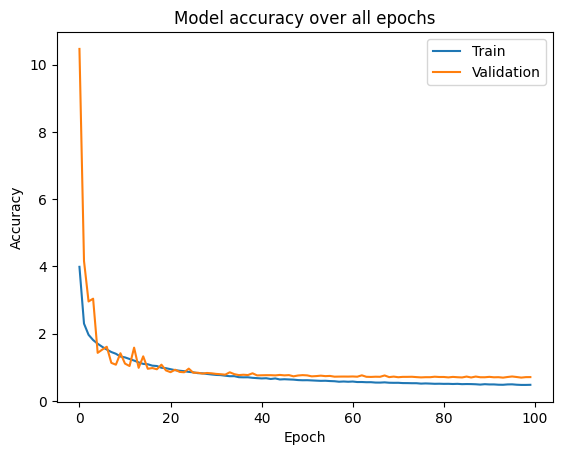

: 

In [ ]:
import glob
import pickle

# Load all history files
history_files = sorted(glob.glob('CNN_MODEL/history_epoch_*.pkl'))

full_history = {}
for file in history_files:
    with open(file, 'rb') as f:
        epoch_history = pickle.load(f)
    for key, values in epoch_history.items():
        full_history.setdefault(key, []).extend(values[len(full_history.get(key, [])):])

# Plot
import matplotlib.pyplot as plt

plt.plot(full_history['loss'])
plt.plot(full_history['val_loss'])
plt.title('Model accuracy over all epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()